# Projeto 2 - Classificador Automático de Sentimento

Você foi contratado por uma empresa parar analisar como os clientes estão reagindo a um determinado produto no Twitter. A empresa deseja que você crie um programa que irá analisar as mensagens disponíveis e classificará como "relevante" ou "irrelevante". Com isso ela deseja que mensagens negativas, que denigrem o nome do produto, ou que mereçam destaque, disparem um foco de atenção da área de marketing.<br /><br />
Como aluno de Ciência dos Dados, você lembrou do Teorema de Bayes, mais especificamente do Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser relevante dadas as palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, você precisa implementar uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o seu protótipo poderá também capturar e classificar automaticamente as mensagens da plataforma.

## Informações do Projeto

Prazo: 13/Set até às 23:59.<br />
Grupo: 1 ou 2 pessoas.<br /><br />
Entregáveis via GitHub: 
* Arquivo notebook com o código do classificador, seguindo as orientações abaixo.
* Arquivo Excel com as bases de treinamento e teste totalmente classificado.

**NÃO disponibilizar o arquivo com os *access keys/tokens* do Twitter.**


### Check 3: 

Até o dia 06 de Setembro às 23:59, o notebook e o xlsx devem estar no Github com as seguintes evidências: 
    * Conta no twitter criada.
    * Produto escolhido.
    * Arquivo Excel contendo a base de treinamento e teste já classificado.

Sugestão de leitura:<br />
http://docs.tweepy.org/en/v3.5.0/index.html<br />
https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

___

## Preparando o ambiente

Instalando a biblioteca *tweepy* para realizar a conexão com o Twitter:

In [333]:
%%capture

#Instalando o tweepy
!pip install tweepy

Importando as Bibliotecas que serão utilizadas. Esteja livre para adicionar outras.

In [334]:
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle

___
## Autenticando no  Twitter

Para realizar a captura dos dados é necessário ter uma conta cadastrada no twitter:

* Conta: *** @Rebecamoreno_***


1. Caso ainda não tenha uma: https://twitter.com/signup
1. Depois é necessário registrar um app para usar a biblioteca: https://apps.twitter.com/
1. Dentro do registro do App, na aba Keys and Access Tokens, anotar os seguintes campos:
    1. Consumer Key (API Key)
    1. Consumer Secret (API Secret)
1. Mais abaixo, gere um Token e anote também:
    1. Access Token
    1. Access Token Secret
    
1. Preencha os valores no arquivo "auth.pass"

**ATENÇÃO**: Nunca divulgue os dados desse arquivo online (GitHub, etc). Ele contém as chaves necessárias para realizar as operações no twitter de forma automática e portanto é equivalente a ser "hackeado". De posse desses dados, pessoas mal intencionadas podem fazer todas as operações manuais (tweetar, seguir, bloquear/desbloquear, listar os seguidores, etc). Para efeito do projeto, esse arquivo não precisa ser entregue!!!

In [335]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @fulano

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Coletando Dados

Agora vamos coletar os dados. Tenha em mente que dependendo do produto escolhido, não haverá uma quantidade significativa de mensagens, ou ainda poder haver muitos retweets.<br /><br /> 
Configurando:

In [336]:
#Produto escolhido:
produto = 'Nutella'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [337]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang).items():    
    msgs.append(msg.text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [338]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

___
## Classificando as Mensagens

Agora você deve abrir o arquivo Excel com as mensagens capturadas e classificar na Coluna B se a mensagem é relevante ou não.<br /> 
Não se esqueça de colocar um nome para a coluna na célula **B1**.<br /><br />
Fazer o mesmo na planilha de Controle.

___
## Montando o Classificador Naive-Bayes

Com a base de treinamento montada, comece a desenvolver o classificador. Escreva o seu código abaixo:

Opcionalmente: 
* Limpar as mensagens removendo os caracteres: enter, :, ", ', (, ), etc. Não remover emojis.<br />
* Corrigir separação de espaços entre palavras e/ou emojis.
* Propor outras limpezas/transformações que não afetem a qualidade da informação.



In [339]:
dft = pd.read_excel('./{0}.xlsx'.format(produto),sheet='Treinamento')
dftsim = dft[(dft.Relevante=="Sim")]
dftnao = dft[(dft.Relevante=="Não")]

In [340]:
lendo = pd.ExcelFile('./{0}.xlsx'.format(produto))
dfteste = lendo.parse("Teste")

In [354]:
def limpadorcaracter(frase):
    #rodando para cada palavra da frase recebida 
    for palavra in frase.split():
        #rodando para cada letra da palavra
        for letras in palavra:
            if letras == '@' or 'https' in palavra or 'kk' in palavra or 'kkk' in palavra:
                frase = frase.replace(palavra,"").replace('  ',' ')
            if not '@' in palavra and (letras == (",") or letras == "'" or letras == '"' or letras == '[' or letras == '‹' or letras == ']' or letras == '#' or letras == ':' or letras == ';' or letras == '›' or letras == '!' or letras == '(' or letras == ')' or letras == '/' or letras == '\n' or letras == '.' or letras == '\\' or letras == '-' or letras == '$' or letras == '%' or letras == '|' or letras == '=' or letras == '*' or letras == 'ˆ' or letras == '&' or letras == '+' or letras == ('?')):
                palavra = palavra.replace(letras," ")
                frase = frase.replace(letras," ")
    return frase

# A, S e N são dicionários com as frequências de cada uma das palavras separadas (splitadas).
A = {}
S = {}
N = {}
todas = 0
c=0
#para cada post (msg)
for msg in dft["Treinamento"]:
    #para cada palavra dentro do post (i)
    frase = limpadorcaracter(msg)
    for i in frase.split():
        #analisando cada palavra ja separada (for e if)
        #contando sua frenquencia e adicionando em A
        if not i in A:
            A[i]=0
        A[i]+=1
        todas+=1
        if A[i]>=c:
            c=A[i]
            string = i

print('Como curiosidade, a palavra que aparece com mais frequência em toda essa análise é a palavra "{0}", com uma frenquência de {1} vezes.\n'.format(string,c))
todas_em_sim = 0
p = 0
#para cada post (msg)
for msg in dftsim["Treinamento"]:
    #para cada palavra dentro do post (i)
    frase = limpadorcaracter(msg)
    for i in frase.split():
        #analisando cada palavra ja limpa
        #contando sua frenquencia e adicionando em A
        if not i in S:
            S[i]=0
        S[i]+=1
        todas_em_sim+=1
        if S[i]>=p:
            p=S[i]
            strings = i
            
print('Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de RELEVANTES é a palavra "{0}", com uma frenquência de {1} vezes.\n'.format(strings,p))
todas_em_nao = 0
f = 0
#para cada post (msg)
for msg in dftnao["Treinamento"]:
    #para cada palavra dentro do post (i)
    frase = limpadorcaracter(msg)
    for i in frase.split():
        #analisando cada palavra ja separada (for e if)
        #contando sua frenquencia e adicionando em A
        if not i in N:
            N[i]=0
        N[i]+=1
        todas_em_nao+=1
        if N[i]>=f:
            f=N[i]
            stringn = i
print(A)                     
print('Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de NÃO RELEVANTES é a palavra "{0}", com uma frenquência de {1} vezes.\n'.format(stringn,f))
print('A quantidade TOTAL de palavras no UNIVERSO é {0}.'.format(todas))
print('A quantidade TOTAL de palavras dentro de RELEVANTES é {0}.'.format(todas_em_sim))
print('A quantidade TOTAL de palavras dentro de NÃO RELEVANTES é {0}.\n'.format(todas_em_nao))
print('A quantidade de palavras DIFERENTES no UNIVERSO é {0}.'.format(len(A)))
print('A quantidade de palavras DIFERENTES dentro de RELEVANTES é {0}.'.format(len(S)))
print('A quantidade de palavras DIFERENTES dentro de NÃO RELEVANTES é {0}.'.format(len(N)))

Como curiosidade, a palavra que aparece com mais frequência em toda essa análise é a palavra "nutella", com uma frenquência de 228 vezes.

Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de RELEVANTES é a palavra "nutella", com uma frenquência de 140 vezes.

{'rt': 95, '2017': 6, 'cê': 3, 'acredita': 3, 'voz': 3, 'de': 153, 'mongoloide': 3, 'do': 24, 'mc': 3, 'kevinho': 3, 'banheira': 4, 'nutella': 228, 'eu': 58, 'sou': 7, 'uma': 25, 'foca': 3, 'porra': 3, 'tá': 11, 'parabéns': 5, 'vc': 12, 'amores': 1, 'cadê': 2, 'vocês': 1, 'me': 22, 'mandando': 1, 'as': 12, 'sugestões': 1, 'dos': 3, 'desafiotamarabellan': 1, 'vou': 15, 'fazer': 6, 'com': 60, 'a': 50, 'hehehe': 1, 'funk': 1, 'tacataca…': 1, 'algum': 1, 'dia': 6, 'pensa': 2, 'em': 26, 'ter': 7, 'filhos': 1, 'sim': 3, 'nao': 5, 'entendi': 1, 'so': 3, 'porque': 4, 'ta': 7, 'final': 4, 'e': 81, 'amém': 1, 'vamos': 2, 'poder': 1, 'trocar': 1, 'nudes': 1, 'novamente': 1, 'ilha': 1, 'uruburguês': 1, 'agor

In [353]:
#Calculando a probabilidade de cada palavra
#Conta: P(sim|palavra)=(P(palavra|sim)+1) / P(palavras totais|sim)+P(palavras totais sem repetição)
bs = todas_em_sim
bn = todas_em_nao
c = len(A)
PS = {}
PN = {}
TSim = dftsim["Treinamento"].count()
TNao = dftnao["Treinamento"].count()
TTotal = dft["Treinamento"].count()
ListaPtweetS=[]
ListaPtweetN=[]
Resultado=[]
addmsgs = []
#PTeste = {}

for msg2 in dfteste['Teste']:
    #Para sim:
    PtweetS = (TSim/TTotal)
    for i in msg2.split():
        #analisando cada palavra ja separada (for e if)
        for caracter in range(0,len(i)):
            i = i.strip(",").strip("'").strip('"').strip('#').strip(':').strip(';').strip('!').strip('(').strip(')').strip('/').strip('\n').strip('.').strip('\\').strip('-').strip('$').strip('%').strip('|').strip('=').strip('*').strip('ˆ').strip('&').strip('+').strip('?')
        #contando sua frenquencia e adicionando em A
        
        if i in S:
            PS[i] = (S[i]+1)/(bs+c)
            
        else:
            PS[i] = 1/(bs+c)
            
        PtweetS = PtweetS*PS[i]
    ListaPtweetS.append(PtweetS)
    addmsgs.append(msg2)
        
    #Para não:
    PtweetN = (TNao/TTotal)
    for i in msg2.split():
        #analisando cada palavra ja separada (for e if)
        for caracter in range(0,len(i)):
            i = i.strip(",").strip("'").strip('"').strip('#').strip(':').strip(';').strip('!').strip('(').strip(')').strip('/').strip('\n').strip('.').strip('\\').strip('-').strip('$').strip('%').strip('|').strip('=').strip('*').strip('ˆ').strip('&').strip('+').strip('?')
        #contando sua frenquencia e adicionando em A
        
        if i in N:
            PN[i] = (N[i]+1)/(bn+c)
            
        else:
            PN[i] = 1/(bn+c)
        
        PtweetN = PtweetN*PN[i]
    ListaPtweetN.append(PtweetN)
    #addmsgs.append(msg2)
        
for i in range(len(ListaPtweetS)):
    #print(ListaPtweetS[i])
    #print(ListaPtweetN[i])
    if ListaPtweetS[i]>ListaPtweetN[i]:
        Resultado.append("Sim")
    if ListaPtweetN[i]>ListaPtweetS[i]:
        Resultado.append("Não")


dfteste["Resultado"] = Resultado

___
## Verificando a performance

Agora você deve testar o seu Classificador com a base de Testes.<br /><br /> 

Você deve extrair as seguintes medidas:
* Porcentagem de positivos falsos (marcados como relevante mas não são relevantes)
* Porcentagem de positivos verdadeiros (marcado como relevante e são relevantes)
* Porcentagem de negativos verdadeiros (marcado como não relevante e não são relevantes)
* Porcentagem de negativos falsos (marcado como não relevante e são relevantes)

Opcionalmente:
* Criar categorias intermediárias de relevância baseado na diferença de probabilidades. Exemplo: muito relevante, relevante, neutro, irrelevante e muito irrelevante.

In [351]:
Igual = 0
Diferente = 0
for i in range(dfteste["Teste"].count()):
    if dfteste["Relevante"][i] == dfteste["Resultado"][i]:
        Igual+=1
    else:
        Diferente+=1
        
print('iguais {0}'.format(Igual))
print(Diferente)

iguais 167
33


In [355]:
#definindo as variaveis para confirmar os positivos e negativos
PosFalso = 0
PosVer = 0
NegVer = 0
NegFalso = 0
PeN = []

for i in range(dfteste["Teste"].count()):
    #confirmando
    if dfteste["Relevante"][i]=='Não' and dfteste["Resultado"][i]=='Sim':
        PosFalso+=1
        PeN.append('Positivo Falso')

    if dfteste["Relevante"][i]=='Sim' and dfteste["Resultado"][i]=='Sim':
        PosVer+=1
        PeN.append('Positivo Verdadeiro')
        
    if dfteste["Relevante"][i]=='Não' and dfteste["Resultado"][i]=='Não':
        NegVer+=1
        PeN.append('Negativo Verdadeiro')
        
    if dfteste["Relevante"][i]=='Sim' and dfteste["Resultado"][i]=='Não':
        NegFalso+=1
        PeN.append('Negativo Falso')        

dfteste["pn"] = PeN
dfteste

,Teste,Relevante,Resultado,pn
0,rt @br00talgirl: espero um dia ser feliz igual...,Não,Sim,Positivo Falso
1,adicionei um vídeo a uma playlist @youtube htt...,Sim,Sim,Positivo Verdadeiro
2,@pedronic_ @sleepool @gabriel0h @prdww lucas n...,Não,Não,Negativo Verdadeiro
3,preciso ir na casa do gui pra comer nutella kkj,Sim,Sim,Positivo Verdadeiro
4,"comecei ser fitness hj, comendo um bolo no pot...",Sim,Sim,Positivo Verdadeiro
5,nutella logo de manhã ❤️,Sim,Sim,Positivo Verdadeiro
6,passando a banana na nutella sem duplo sentido,Sim,Não,Negativo Falso
7,tanto doce pra harmonizar e vcs insistem nessa...,Sim,Sim,Positivo Verdadeiro
8,"rt @ac_bulhoes: essa sua pele preta, nutella, ...",Não,Não,Negativo Verdadeiro
9,queria comer outra nutella,Sim,Sim,Positivo Verdadeiro


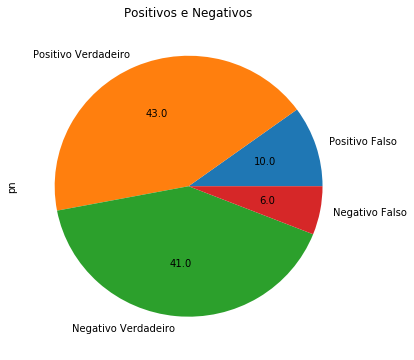

In [356]:
import matplotlib.pyplot as plt
k = dfteste.pn.value_counts()/len(PeN)*100
s = k.reindex(['Positivo Falso','Positivo Verdadeiro','Negativo Verdadeiro','Negativo Falso'])
plot = s.plot(kind='pie',title='Positivos e Negativos',autopct='%.1f',figsize=(6, 6))
plt.show()

___
## Concluindo

Escreva aqui a sua conclusão.<br /> 
Faça um comparativo qualitativo sobre as medidas obtidas.<br />
Explique como são tratadas as mensagens com dupla negação e sarcasmo.<br />
Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?<br />

Opcionalmente: 
* Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.
* Propor diferentes cenários de uso para o classificador Naive-Bayes. Cenários sem intersecção com este projeto.
* Sugerir e explicar melhorias reais no classificador com indicações concretas de como implementar (não é preciso codificar, mas indicar como fazer e material de pesquisa sobre o assunto).
